# Problem 1: Bayesian Density Estimation
By: Griffin Hosseinzadeh (2025 May 6)  
Inspired by a notebook by LM Walkowicz (2019 June 14)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as viz
from scipy import stats
from sklearn.neighbors import KernelDensity

Here I'm simulating some data. Just run this cell to generate a list of values `x`.

In [3]:
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]

Make a histogram of these values using `plt.hist`. (Use `density=True` throughout this exercise, so the y-axes are comparable.) How many peaks does this data set have?

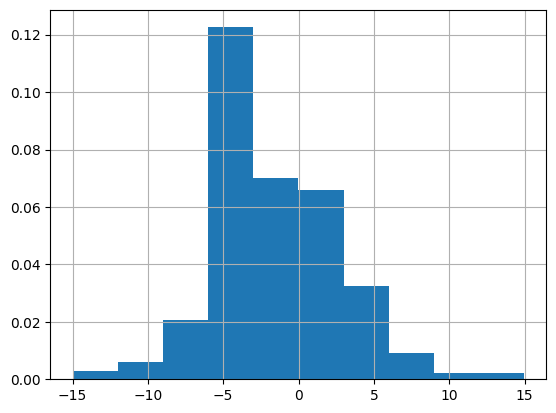

In [4]:
plt.hist(x, density=True)
plt.grid(True)

Now make a histogram using the `'auto'` binning in Matplotlib. What does it think the right number of bins should be? How many peaks does this data set have?

42 bins


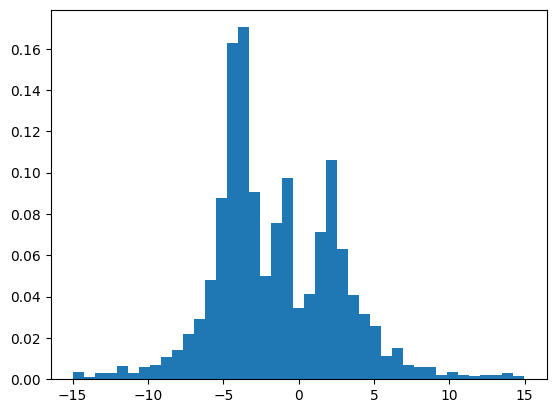

In [5]:
n, b, p = plt.hist(x, 'auto', density=True)
print(len(b), 'bins')

Increase the number of bins even further. Is there a point where it gets too high? If so, why?

(array([0.0046515 , 0.00232575, 0.00232575, 0.00077525, 0.0015505 ,
        0.00387625, 0.003101  , 0.00232575, 0.00387625, 0.003101  ,
        0.00697724, 0.00697724, 0.00387625, 0.0015505 , 0.006202  ,
        0.00232575, 0.00775249, 0.00852774, 0.00542675, 0.01085349,
        0.01085349, 0.01007824, 0.01240399, 0.01395449, 0.01938124,
        0.01783074, 0.02480798, 0.02713373, 0.03876247, 0.03178523,
        0.04961596, 0.05814371, 0.0689972 , 0.11241117, 0.12559041,
        0.17365587, 0.20621634, 0.18683511, 0.13411815, 0.11008542,
        0.07519919, 0.0658962 , 0.05039121, 0.04573972, 0.04573972,
        0.08760318, 0.14109539, 0.10388342, 0.04573972, 0.04031297,
        0.02945948, 0.03721197, 0.04031297, 0.04961596, 0.06977245,
        0.07985069, 0.11783791, 0.10155767, 0.07364869, 0.0596942 ,
        0.0658962 , 0.04961596, 0.04108822, 0.02790898, 0.03333572,
        0.02868423, 0.02403273, 0.03178523, 0.00852774, 0.01240399,
        0.01395449, 0.01317924, 0.01705549, 0.00

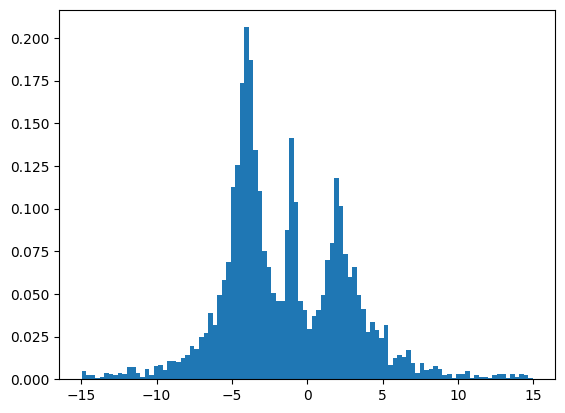

In [6]:
plt.hist(x, bins=100, density=True)

Now make a histogram using Bayesian blocks. Hint: try the `astropy.visualization.hist` function. How many bins does this have? Can you see all the peaks?

20 bins


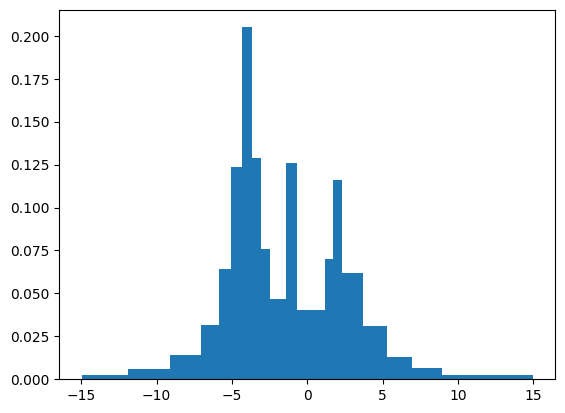

In [7]:
n, b, p = viz.hist(x, bins='blocks', density=True)
print(len(b), 'bins')

Try making the Bayesian blocks histogram *without* `density=True`. What do you notice? Is this a good idea?

20 bins


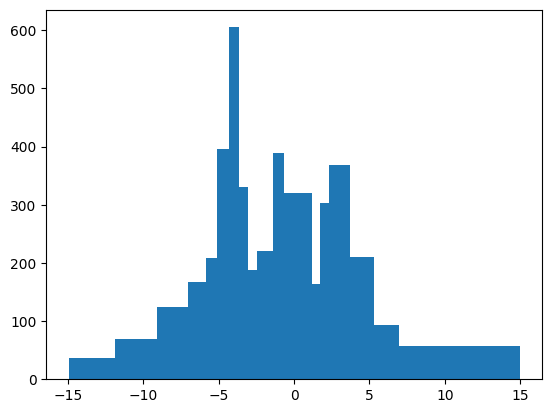

In [8]:
n, b, p = viz.hist(x, bins='blocks')
print(len(b), 'bins')

Now let's try making a KDE instead. Try a few different values for the bandwidth until you find one you like.

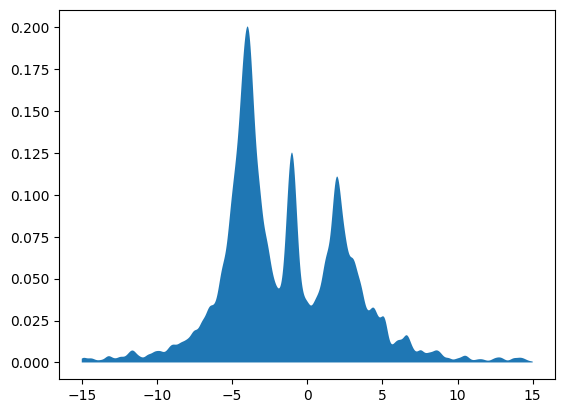

In [11]:
x_reshaped = x[:, np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_reshaped)

x_fit = np.linspace(-15, 15, 1000)[:, np.newaxis]

log_dens = kde.score_samples(x_fit)
y_fit = np.exp(log_dens)
plt.fill_between(x_fit[:,0], y_fit)
plt.show()

Plot all of these density estimates on top of each other using `histtype='step'` and compare them.

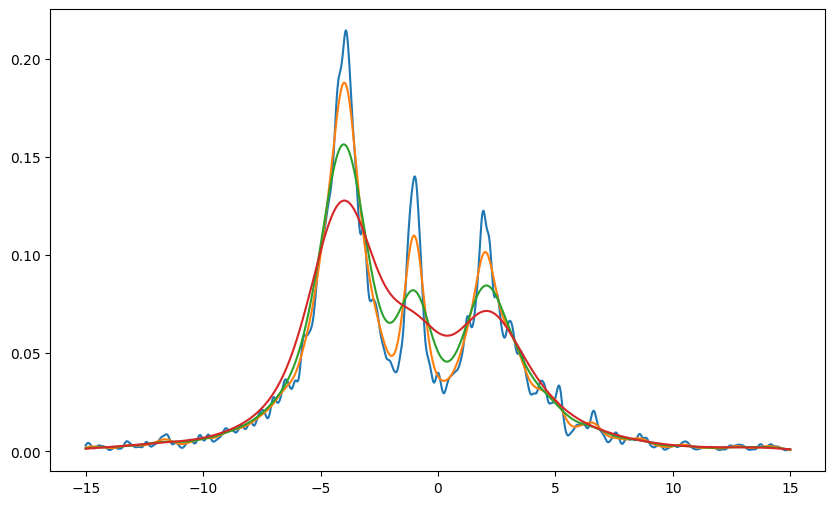

In [12]:
x_reshaped = x[:, np.newaxis]
x_fit = np.linspace(-15, 15, 1000)[:, np.newaxis]

bandwidths = [0.1, 0.3, 0.6, 1.0]

plt.figure(figsize=(10, 6))
for bw in bandwidths:
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(x_reshaped)
    log_dens = kde.score_samples(x_fit)
    y_fit = np.exp(log_dens)
    plt.plot(x_fit[:, 0], y_fit, label=f'bandwidth = {bw}')

# Problem 2: Gaussian Process Regression
By: Griffin Hosseinzadeh (2019 April 17)  
Updated 2025 May 6

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import george
from astropy.table import Table
from george.kernels import ExpSquaredKernel

## Read the Light Curve
I have given you light curve data for the Type Ibn supernova PTF11rfh in the file `PTF11rfh.table`, which is readable with the `astropy.table` module. (Hint: `format='ascii.fixed_width'`.) For this example, let's fit the light curve in counts rather than magnitudes. Select only points observed in the $r$ or $R$ filter and have a measurement in counts. Plot it to see what we're working with. (For non-astronomers, MJD is a measure of time in days.)

In [26]:
data = Table.read("PTF11rfh.table", format="ascii.fixed_width") # complete
data = data[(data['filt'] == 'r') | (data['filt'] == 'R')] # select r/R-band
data

MJD,counts,dcounts,zp,nondet,filt,source,mag,dmag,limmag,flam,dflam
float64,float64,float64,float64,str5,str4,str5,float64,float64,float64,float64,float64
55889.091,19.7,36.8,27.0,True,R,P48,21.89257731651705,nan,--,--,--
55889.125,22.2,45.1,27.0,True,R,P48,21.671755508505942,nan,--,--,--
55889.167,-7.8,49.6,27.0,True,R,P48,21.56849267197535,nan,--,--,--
55891.167,-17.1,54.8,27.0,True,R,P48,21.46024546698992,nan,--,--,--
55892.099,99.8,107.9,27.0,True,R,P48,20.724643251493568,nan,--,--,--
55892.142,-128.1,64.0,27.0,True,R,P48,21.291746928241125,nan,--,--,--
55892.178,-13.6,107.1,27.0,True,R,P48,20.732723186121206,nan,--,--,--
55893.098,-57.5,56.9,27.0,True,R,P48,21.419416197213167,nan,--,--,--
55893.136,-85.3,64.3,27.0,True,R,P48,21.28666943089029,nan,--,--,--


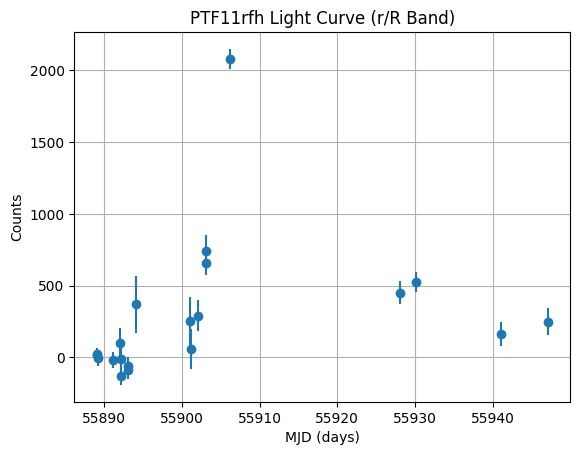

In [27]:
x = data['MJD'] # complete
y = data['counts'] # complete
dy = data['dcounts'] # complete

# plot
plt.errorbar(x, y, yerr=dy, fmt='o')
plt.xlabel('MJD (days)')
plt.ylabel('Counts')
plt.title('PTF11rfh Light Curve (r/R Band)')
plt.grid(True)

## Try a Polynomial Fit
Hint: use `np.polyfit` and `np.polyval`. Try different degree polynomials to see if you are able to get a good fit.

C:\Users\acort\AppData\Local\Temp\ipykernel_20504\1529647167.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg)
C:\Users\acort\AppData\Local\Temp\ipykernel_20504\1529647167.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg)


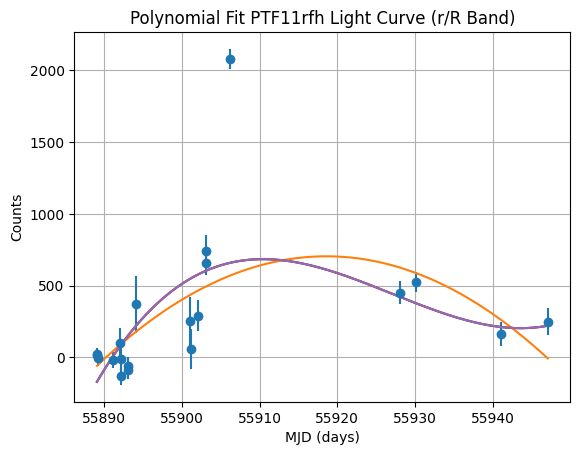

In [28]:
x_fit = np.linspace(min(x), max(x), 500) # complete

degrees = [2, 3, 5, 7]

plt.errorbar(x, y, yerr=dy, fmt='o')
for deg in degrees:
    coeffs = np.polyfit(x, y, deg)
    y_fit_poly = np.polyval(coeffs, x_fit)
    plt.plot(x_fit, y_fit_poly)

plt.xlabel('MJD (days)')
plt.ylabel('Counts')
plt.title('Polynomial Fit PTF11rfh Light Curve (r/R Band)')
plt.grid(True)

Don't spend too much time on this. I could not get it to give a reasonable result.

## Try a Gaussian Process
We are using a package called `george` to make Gaussian process regression easier. It has all of the functions you need build in.

First we need to initialize a kernel (`george.kernels`). You should normalize the kernel by the total variance of the data points. Think about what hyperparameters would be appropriate for fitting your data. We can always optimize them later.

In [29]:
y_var = np.var(y)

kernel = y_var * ExpSquaredKernel(metric=10.0)

Initialize a Gaussian process with the kernel you chose. This is all contained within the `george.GP` object, which we will use for the remainder of the calculations.

In [30]:
gp = george.GP(kernel)

The first step is to precompute the covariance matrix at the observed times.

In [31]:
gp.compute(x, dy)

The second and last step is to use the Gaussian process to predict the light curve at the times in `x_fit`, given the observed data points in `y`. This should give you an interpolation **and** and uncertainty on the interpolation.

In [32]:
x_fit = np.linspace(min(x), max(x), 500)

y_pred, y_pred_var = gp.predict(y, x_fit, return_var=True)

Plot the results of your Gaussian process fit and compare to the data and the polynomial fit. Hint: display the uncertainties using `plt.fill_between`.

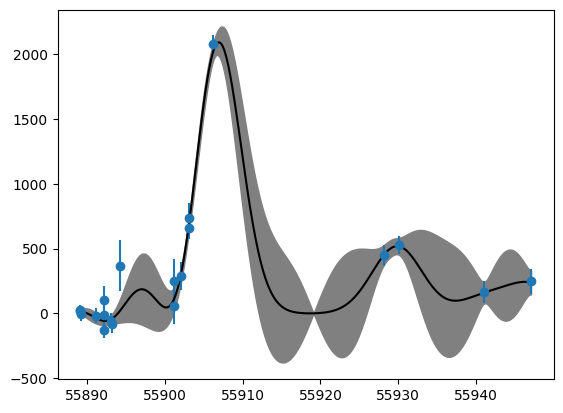

In [33]:
y_pred_std = np.sqrt(y_pred_var)

plt.errorbar(x, y, yerr=dy, fmt='o', label='Observed data')
plt.plot(x_fit, y_pred, label='GP Prediction', color='black')
plt.fill_between(x_fit, y_pred - y_pred_std, y_pred + y_pred_std,
                 color='gray', label='1σ uncertainty')

Once you get a reasonable fit, try adjusting the kernel and/or hyperparameters to see what effects they have.

## Take-Away Message
Gaussian process regression is a very easy and powerful way to interpolate an arbitrary set of data points with a nonparametric function. Furthermore, it gives you uncertainties on the interpolation and handles covariance between points correctly.

## Other Things to Try (Optional)
- Optimize the Gaussian process using the technique described in the George tutorial: https://george.readthedocs.io/en/latest/tutorials/first/.
- Marginalize over the hyperparameter(s) using MCMC.
- Try products of different kernels to see if you can get a better fit.